In [97]:
import numpy as np 
import pandas as pd
import statsmodels.api as sm
from scipy.special import gamma
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
def solve_equilibrium(T_c, T_k, t_ck, theta, rho, alpha, eta):
    # Set the initial values and flatten for solver
    rows = T_c.shape[0]
    cols = T_k.shape[0]
    w_ck = np.ones((rows, cols)).flatten()

    def objective(w_ck):
        # Reshape the input to the correct shape
        lambda_k = np.sum(w_ck ** (theta / (1 - rho)), axis=0) 
        # lambda_k = np.sum(w_ck ** (theta), axis=0)
        w_ck = w_ck.reshape((rows, cols))

        Z_ck = gamma((theta - 1) / theta) * (w_ck ** (theta - 1)) * (np.sum(w_ck ** theta, axis=0) ** (- rho)) * (np.sum(np.sum(w_ck, axis=0) ** (1 - rho), axis=0) ** ((1 - theta) / theta))

        lhs_first = (w_ck / np.outer(T_c, T_k)) ** (- alpha)
        lhs_second = np.sum((w_ck / np.outer(T_c, T_k)) ** (1 - alpha), axis=0) ** ((alpha - eta) / (1 - alpha))
        lhs_third = np.sum(np.sum((w_ck / np.outer(T_c, T_k)) ** (1 - alpha), axis=0) ** ((1 - eta) / (1 - alpha)), axis=0) ** ((eta - 1) / (1 - eta))
        lhs_fourth = np.sum(w_ck * Z_ck)
        lhs = lhs_first * lhs_second * lhs_third * lhs_fourth

        rhs = gamma((theta - 1) / theta) * np.outer(T_c, T_k) * (w_ck ** (theta - 1)) * (lambda_k ** (-rho)) * (np.sum(lambda_k ** (1 - rho), axis=0) ** ((1 - theta) / theta))

        # Return the objective function which is the difference between Q and Y
        return np.sum(lhs - rhs) ** 2

    # Minimize the objective function
    w_ck = minimize(objective, w_ck, method='L-BFGS-B').x.reshape((rows, cols))

    # Calculate the rest of the equilibrium
    # lambda_k = np.sum(w_ck ** (theta / (1 - rho)), axis=0)
    # pi_ck = (w_ck ** (theta / (1 - rho))) / lambda_k
    # pi_ck = (w_ck ** (theta)) / lambda_k
    lambda_k = np.sum(w_ck ** (theta / (1 - rho)), axis=0)
    pi_ck_left  = (w_ck ** (theta / (1 - rho))) / lambda_k
    pi_ck_right = (lambda_k ** (1 - rho)) / np.sum(lambda_k ** (1 - rho), axis=0)
    pi_ck = pi_ck_left * pi_ck_right

    # pi_c_top = np.sum((w_ck ** (theta / (1 - rho))) * (lambda_k ** (- rho)), axis=1)
    pi_c_top = np.sum((w_ck ** (theta / (1 - rho))) * (lambda_k ** (- rho)), axis=1)
    pi_c_bottom = np.sum(lambda_k ** (1 - rho), axis=0)
    pi_c = pi_c_top / pi_c_bottom

    return pi_c, pi_ck, w_ck

In [99]:
cz = pd.read_csv('../data/raw/archive/cz_county.csv')
cz = cz.dropna()
cz['LMA/CZ'] = cz['LMA/CZ'].astype(str).str[:-2].astype(int)
idx = cz.groupby(['LMA/CZ'])['Labor Force'].idxmax()
cz = cz.loc[idx].reset_index(drop=True)
cz = cz[['LMA/CZ', 'County Name']].set_index('LMA/CZ')
cz['County Name'] = cz['County Name'].str.replace('"', '')

In [100]:
theta = 3
rho = 0.5
alpha = 7
eta = 1.65

In [101]:
df_employment = pd.read_csv('../data/processed/city_occ_employment/city_occ_e_1990.csv')
df_employment = df_employment.drop(columns=['other'])
df_employment['COMZONE'] = df_employment['COMZONE'].map(cz['County Name'])
df_employment = df_employment.set_index('COMZONE')

rows = df_employment.index
cols = df_employment.columns

df_employment['cz_total'] = df_employment.sum(axis=1)
df_employment.loc['occ_total'] = df_employment.sum(axis=0)
df_employment = df_employment.div(df_employment['cz_total']['occ_total'], axis=1)

omega_k = df_employment.loc['occ_total'].drop('cz_total').to_numpy()
df_employment = df_employment.drop(index='occ_total').drop(columns='cz_total').to_numpy()

df_wages = pd.DataFrame((df_employment ** (1 / theta)) * (omega_k ** (rho / (theta * (1 - rho)))))
df_wages.columns = cols
df_wages.index = rows

In [102]:
w_ck = df_wages.fillna(0).to_numpy()

lambda_k = (w_ck ** (theta / (1 - rho))).sum(axis=0)
Z_ck = gamma(theta - 1 / theta) * (w_ck ** theta) * (lambda_k ** (- rho)) * np.sum((lambda_k ** (1 - rho)) ** ((1 - theta) / theta), axis=0)

T_ck_left = (w_ck ** (- (alpha) / (1 - alpha))) / (Z_ck ** (1 / (1 - alpha)))
T_ck_right = np.repeat(np.sum(w_ck * Z_ck, axis=0).reshape(1, -1), w_ck.shape[0], axis=0) ** (1 / (1 - alpha))
T_ck = np.log(T_ck_left * T_ck_right)
T_ck = pd.DataFrame(np.where(np.isinf(T_ck), np.nan, T_ck))

T_ck.columns = df_wages.columns
T_ck['COMZONE'] = df_wages.index
T_ck = pd.melt(T_ck, id_vars=['COMZONE'], var_name='occupation', value_name='wage')

/tmp/ipykernel_2206439/3121774865.py:6: RuntimeWarning: divide by zero encountered in power
  T_ck_left = (w_ck ** (- (alpha) / (1 - alpha))) / (Z_ck ** (1 / (1 - alpha)))
/tmp/ipykernel_2206439/3121774865.py:8: RuntimeWarning: divide by zero encountered in log
  T_ck = np.log(T_ck_left * T_ck_right)


In [103]:
model = sm.OLS.from_formula('wage ~ C(occupation) + C(COMZONE)', data=T_ck)

model = model.fit()
coefficients = model.params
T_ck['residual'] = model.resid

T_k = pd.DataFrame(coefficients[coefficients.index.str.contains('occupation')]).reset_index()
T_k['occupation'] = T_k['index'].str.extract(r'C\(occupation\)\[T\.(.*?)\]')
T_k = T_k.drop(columns=['index']).rename(columns={0: 'coefficient'})
T_k = T_k[['occupation', 'coefficient']]
T_k['coefficient'] = np.exp(T_k['coefficient'])

T_c = pd.DataFrame(coefficients[coefficients.index.str.contains('COMZONE')]).reset_index()
T_c['COMZONE'] = T_c['index'].str.extract(r'C\(COMZONE\)\[T\.(.*?)\]')
T_c = T_c.drop(columns=['index']).rename(columns={0: 'coefficient'})
T_c = T_c[['COMZONE', 'coefficient']]
T_c['coefficient'] = np.exp(T_c['coefficient'])

t_ck = T_ck.pivot(index='COMZONE', columns='occupation', values='residual')
t_ck = t_ck.apply(lambda x: np.exp(x))

folder = 'results/2009/params/r5/'

T_c.to_csv(f'{folder}T_c.csv', index=False)
T_k.to_csv(f'{folder}T_k.csv', index=False)
t_ck.to_csv(f'{folder}t_ck.csv')

In [104]:
phi_ck = pd.read_csv('../data/processed/city_occ_employment/city_occ_e_2009.csv')

# lambda_k = np.sum(w_ck ** theta, axis=0)
# phi_ck = ((w_ck ** theta) * (lambda_k ** (- rho))) / np.sum(((w_ck ** theta) * (lambda_k ** (- rho))), axis=1, keepdims=True)
# phi_ck = pd.DataFrame(phi_ck)
# phi_ck.index = rows
# phi_ck.columns = cols

phi_ck = phi_ck.drop(columns=['other'])
phi_ck['COMZONE'] = phi_ck['COMZONE'].map(cz['County Name'])
phi_ck = phi_ck.set_index('COMZONE')
phi_ck['cz_total'] = phi_ck.sum(axis=1)
phi_ck = phi_ck.div(phi_ck['cz_total'], axis=0)
phi_ck = phi_ck.drop(columns='cz_total')

In [105]:
T_c = T_c.set_index('COMZONE')
T_k = T_k.set_index('occupation')

pi_c, pi_ck, w_ck = solve_equilibrium(T_c['coefficient'], T_k['coefficient'], t_ck, theta, rho, alpha, eta)

pi_ck = pd.DataFrame(pi_ck)
pi_ck.index = T_c.index
pi_ck.columns = T_k.index

pi_c = pd.DataFrame(pi_c)
pi_c.index = T_c.index

In [106]:
occ = 'occ2_mechanic'
# occ = 'occ2_prof'

T_k_shock = T_k.copy()
T_k_shock.loc[occ] *= 0.85

pi_c_shock, pi_ck_shock, w_ck_shock = solve_equilibrium(T_c['coefficient'], T_k_shock['coefficient'], t_ck, theta, rho, alpha, eta)

pi_ck_shock = pd.DataFrame(pi_ck_shock)
pi_ck_shock.index = T_c.index
pi_ck_shock.columns = T_k.index

pi_c_shock = pd.DataFrame(pi_c_shock)
pi_c_shock.index = T_c.index

In [107]:
w_ck = pd.DataFrame(w_ck)
w_ck.index = T_c.index
w_ck.columns = T_k.index

w_ck_shock = pd.DataFrame(w_ck_shock)
w_ck_shock.index = T_c.index
w_ck_shock.columns = T_k.index

folder = 'results/2009/mechanic_shock/r5/'

pi_c.to_csv(f'{folder}pi_c.csv')
pi_ck.to_csv(f'{folder}pi_ck.csv')
w_ck.to_csv(f'{folder}w_ck.csv')

pi_c_shock.to_csv(f'{folder}pi_c_shock.csv')
pi_ck_shock.to_csv(f'{folder}pi_ck_shock.csv')
w_ck_shock.to_csv(f'{folder}w_ck_shock.csv')

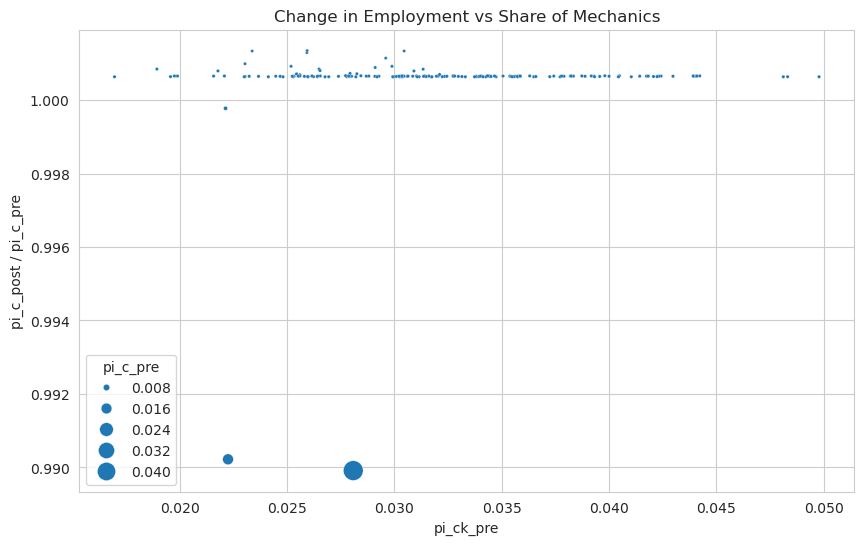

In [108]:
change_pi_c  = pi_c_shock / pi_c

change_pi_c = change_pi_c.merge(phi_ck[occ], left_index=True, right_index=True, how='left')
change_pi_c = change_pi_c.rename(columns={0: 'change'})
change_pi_c = change_pi_c.merge(pi_c, left_index=True, right_index=True, how='left')
change_pi_c = change_pi_c.rename(columns={0: 'pi_c_pre'})

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

sns.scatterplot(x=occ, y='change', size='pi_c_pre', sizes=(5, 200), data=change_pi_c)
plt.xlabel('pi_ck_pre')
plt.ylabel('pi_c_post / pi_c_pre')
plt.title('Change in Employment vs Share of Mechanics')
# plt.savefig('')
plt.show()

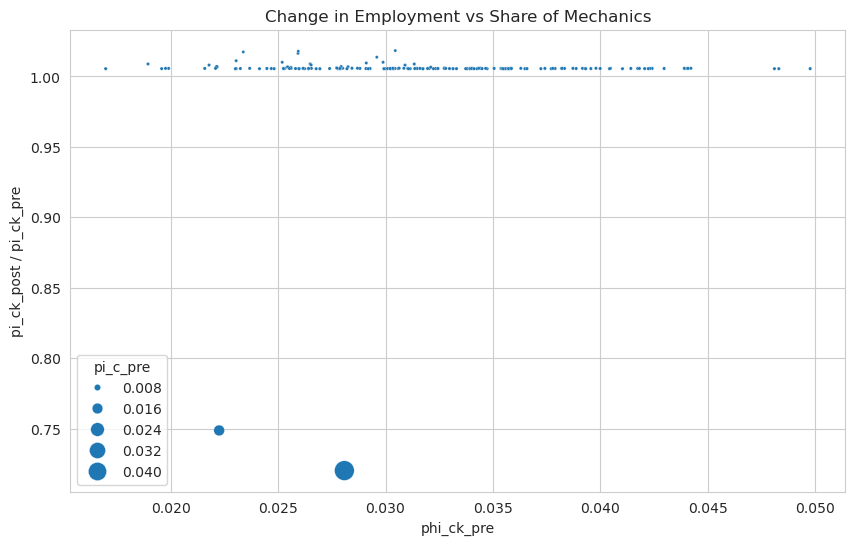

In [109]:
change_pi_ck = (pi_ck_shock / pi_ck)[occ]
change_pi_ck = pd.DataFrame(change_pi_ck).rename(columns={occ: 'change'})
change_pi_ck = change_pi_ck.merge(phi_ck[occ], left_index=True, right_index=True, how='left')
change_pi_ck = change_pi_ck.merge(pi_c, left_index=True, right_index=True, how='left')
change_pi_ck = change_pi_ck.rename(columns={0: 'pi_c_pre'})

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

sns.scatterplot(x=occ, y='change', size='pi_c_pre', sizes=(5, 200), data=change_pi_ck)
plt.xlabel('phi_ck_pre')
plt.ylabel('pi_ck_post / pi_ck_pre')
plt.title('Change in Employment vs Share of Mechanics')
# plt.savefig('')
plt.show()

In [110]:
# w_ck['cz_total'] = w_ck.sum(axis=1)
# w_ck_shock['cz_total'] = w_ck_shock.sum(axis=1)

# pi_ck.loc['occ_total'] = pi_ck.sum(axis=0)
# pi_ck_shock.loc['occ_total'] = pi_ck_shock.sum(axis=0)

In [111]:
# city = 'Queens County, NY'

# T_c_shock = T_c.copy()
# T_c_shock.loc[city] *= 0.85

# pi_c_shock, pi_ck_shock, w_ck_shock = solve_equilibrium(T_c_shock['coefficient'], T_k['coefficient'], t_ck, theta, rho, alpha, eta)

# w_ck_shock = pd.DataFrame(w_ck_shock)
# w_ck_shock.index = T_c.index
# w_ck_shock.columns = T_k.index

# correlation = phi_ck.copy()

# correlation = correlation.apply(lambda row: row.corr(correlation.loc[city]), axis=1)
# correlation.name = 'correlation'

# pi_ck_shock = pd.DataFrame(pi_ck_shock)
# pi_ck_shock.index = T_c.index
# pi_ck_shock.columns = T_k.index
# pi_c_shock = pd.DataFrame(pi_c_shock)
# pi_c_shock.index = T_c.index
# change_pi_c = pi_c_shock / pi_c
# change_pi_c = change_pi_c.merge(correlation, left_index=True, right_index=True, how='left')
# change_pi_c = change_pi_c.rename(columns={0: 'change'})
# change_pi_c = change_pi_c.merge(pi_c, left_index=True, right_index=True, how='left')
# change_pi_c = change_pi_c.rename(columns={0: 'pi_c_pre'})
# change_pi_c = change_pi_c.drop(index=city)

# sns.set_style("whitegrid")
# plt.figure(figsize=(10, 6))

# sns.scatterplot(x='correlation', y='change', size='pi_c_pre', sizes=(5, 200), data=change_pi_c)
# plt.xlabel('Correlation')
# plt.ylabel('pi_c_post / pi_c_pre')
# plt.title('Change in Employment vs Labor Force')
# # plt.savefig('')
# plt.show()

In [112]:
# pi_c_shock.to_csv('results/city_shock/pi_c_shock.csv')
# pi_ck_shock.to_csv('results/city_shock/pi_ck_shock.csv')
# w_ck_shock.to_csv('results/city_shock/w_ck_shock.csv')